# Modelling a Multisectoral Energy System with oemof

### General description:

The jupyter notebook gives a simple example of how to couple the power, heat and mobility sectors.

### Installation requirements:

This example requires the latest oemof version and jupyter. Install by:

    pip install oemof jupyter

## Create a Simple Energy System

![A simple energy system.](images/simple_system.png "Well, this is simple.")

### Initialize the `EnergySystem`

In [2]:
from oemof.solph import EnergySystem
import pandas as pd


energysystem = EnergySystem(
    timeindex=pd.date_range('1/1/2016', periods=168, freq='H')
)

### Import input data

We need some input data so let's read it from a CSV file and store it in a [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) called `data` (duh).  
The data contains scaled demands and feedin timeseries of renewables.

In [3]:
data = pd.read_csv(
    "data/example_data.csv",
    sep=",",
    index_col='timeindex',
    parse_dates=['timeindex'],
)

### Add `Node`s to the `energysystem`

In [4]:
from oemof.solph import Bus, Flow, Sink, Source, Transformer


electricity = Bus(label="Electricity")

excess = Sink(label="Excess electricity", inputs={electricity: Flow()})

shortage = Source(
    label="Electricity shortage",
    outputs={electricity: Flow(variable_costs=1000)},
)

electrical_demand = Sink(
    label="Electrical demand",
    inputs={
        electricity: Flow(
            nominal_value=85, actual_value=data['demand_el'], fixed=True
        )
    },
)

wind = Source(
    label="Wind",
    outputs={
        electricity: Flow(
            actual_value=data['wind'], nominal_value=60, fixed=True
        )
    },
)

solar = Source(
    label="PV",
    outputs={
        electricity: Flow(
            actual_value=data['pv'], nominal_value=200, fixed=True
        )
    },
)

energysystem.add(electricity, excess, shortage, electrical_demand, wind, solar)

### Optimize the `energysystem`

Now that we have an energy system which is populated with some data, let's optimize it.

In [5]:
from oemof.solph import Model

def optimize(energysystem):
    
    ### optimize
    # create operational model
    om = Model(energysystem=energysystem)

    # solve using the cbc solver
    om.solve(solver='cbc',
             solve_kwargs={'tee': False})

    # save LP-file
    om.write('sector_coupling.lp', io_options={'symbolic_solver_labels': True})

    # generic result object
    #results = processing.results(om=om)

    return om

om = optimize(energysystem)

### Plot the results

Ok. That took at least long enought to notice that something was happening, but we don't see anything. Let's try whether we can actually visualise the results.

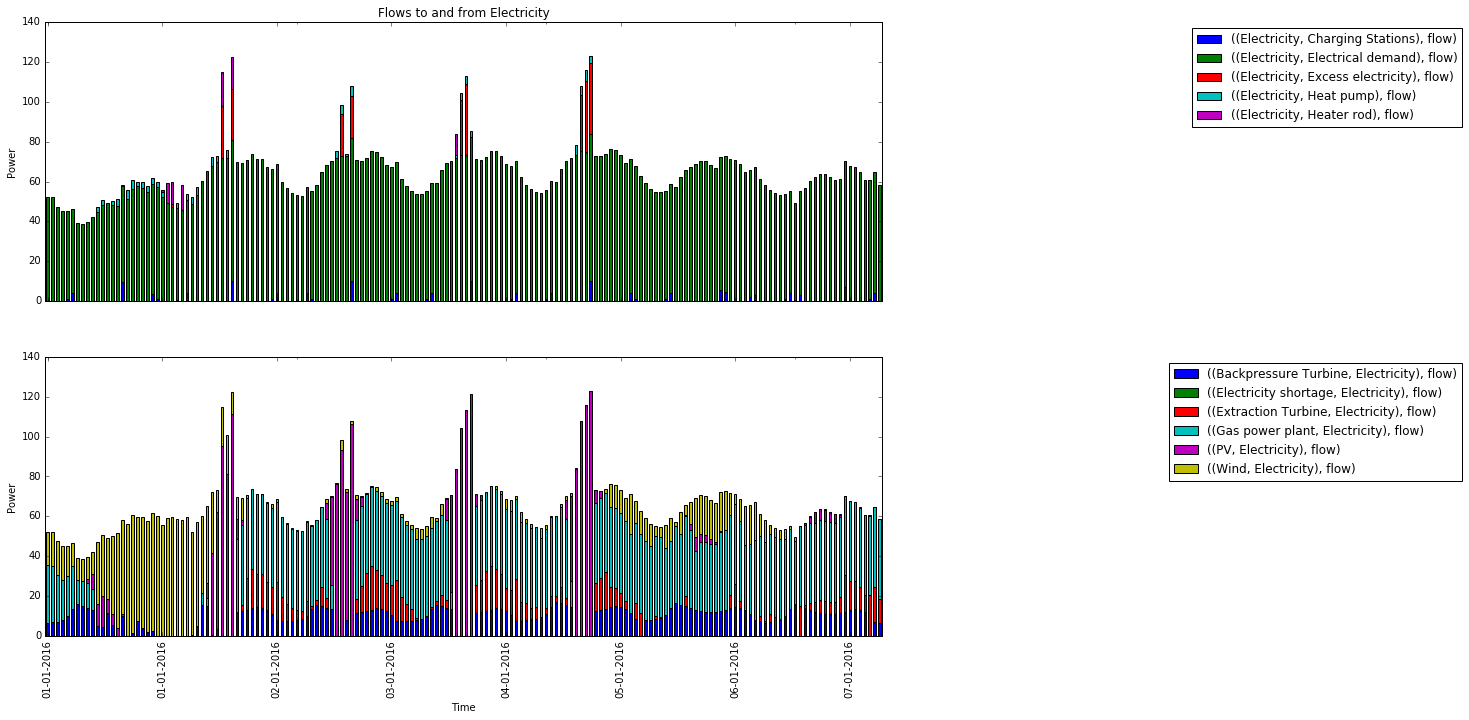

In [43]:
from oemof.outputlib import processing, views
import matplotlib.pyplot as plt
%matplotlib inline


def plot(om, label):
    """ Plot stuff from the `energysystem`.

    Parameters
    ----------
    om : oemof.solph.models.OperationalModel
        The optimisation model containing the object whose information we want
        to plot.
    label : String
        The `label` of the object containing the information to be plotted.
        Said object is assumed to be an `oemof.Bus` instance.
    """

    # node_results is a dictionary keyed by 'scalars' and 'sequences'
    # holding respective data in a pandas Series and DataFrame.
    sequences = views.node(om.results(), label)['sequences']
    to_flows = [flow for flow in sequences.columns if flow[0][0] == label]
    from_flows = [flow for flow in sequences.columns if flow[0][1] == label]

    f, (ax1, ax2) = plt.subplots(2, sharex=True)
    sequences[to_flows].plot(kind='bar', stacked=True, ax=ax1, figsize=(15, 11))
    sequences[from_flows].plot(kind='bar', stacked=True, ax=ax2, figsize=(15, 11))

    ax1.set_title('Flows to and from {}'.format(label))
    ax1.legend(loc='upper right', bbox_to_anchor=(1.7, 1.0))
    ax2.legend(loc='upper right', bbox_to_anchor=(1.7, 1.0))
    ax1.set_ylabel('Power')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Power')

    dates = sequences.index
    tick_distance = int(len(dates) / 7) - 1
    ax2.set_xticks(range(0, len(dates), tick_distance), minor=False)
    ax2.set_xticklabels(
        [
            item.strftime('%d-%m-%Y')
            for item in dates.tolist()[0::tick_distance]
        ],
        rotation=90,
        minor=False,
    )

    plt.show()

plot(om, "Electricity")

## Adding the gas sector

![A simple energy system with a gas power plant.](images/gas_pp.png "Now, this doesn't look so simple anymore.")

In order to add a gas power plant, a gas ressource bus is needed. The gas power plant connects the gas and electricity busses and thereby couples the gas and electricity sector.

In [10]:
gas = Bus(label="Gas", balanced=False)

power_plant = Transformer(
    label="Gas power plant",
    inputs={gas: Flow(summed_max_flow=200)},
    outputs={electricity: Flow(nominal_value=40, variable_costs=40)},
    conversion_factors={electricity: 0.50},
)

energysystem.add(gas, power_plant)

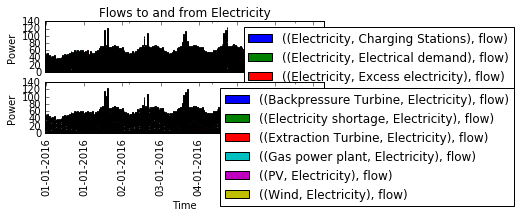

In [37]:
om = optimize(energysystem)
plot(om, 'Electricity')

## Adding the heat sector

![The energy system, now with some heat.](images/heat.png "Bring on the heat.")

The heat sector is added and coupled to the electricity sector similarly to the gas sector. The same component, the LinearTransformer, is used to couple the two sectors. Only through its parametrisation it becomes a heater rod or a heat pump.


In [16]:
heat = Bus(label="Heat", balanced=True)

thermal_demand = Sink(
    label="Thermal demand",
    inputs={
        heat: Flow(
            nominal_value=60, actual_value=data['demand_th'], fixed=True
        )
    },
)

heater = Transformer(
    label="Heater rod",
    inputs={electricity: Flow()},
    outputs={heat: Flow(variable_costs=10)},
    conversion_factors={heat: 0.98},
)

energysystem.add(heat, thermal_demand, heater)

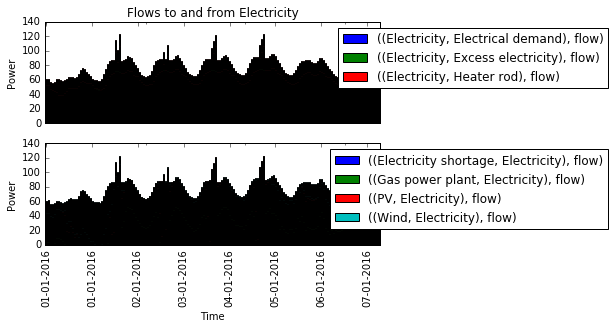

In [18]:
om = optimize(energysystem)
plot(om, 'Electricity')

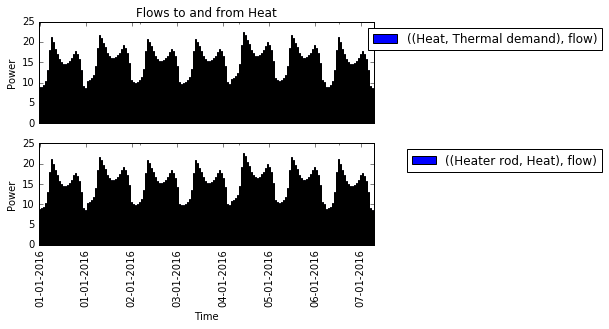

In [19]:
plot(om, 'Heat')

### Adding a heat pump

There are different ways to model a heat pump. Here the approach of precalculating a COP and using this as a conversion factor for the LinearTransformer is used. Another approach is to use the LinearN1Transformer that has two inputs - electricity and heat from a heat source. See the solph example "simple_dispatch".

In [20]:
# The COP can be calculated beforehand, assuming the heat reservoir temperature
# is a random, infinite timeseries.
import numpy as np

COP = np.random.uniform(low=3.0, high=5.0, size=(168,))

heat_pump = Transformer(
    label="Heat pump",
    inputs={electricity: Flow()},
    outputs={heat: Flow(nominal_value=20, variable_costs=10)},
    conversion_factors={heat: COP},
)

energysystem.add(heat_pump)

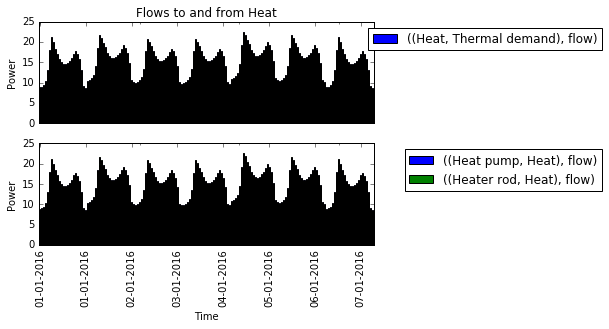

In [21]:
om = optimize(energysystem)
plot(om, 'Heat')

### Adding a combined heat and power plant

![All new, now with a CHP.](images/combined_heat_and_power.png 'CHP rolls off the tongue so much better than "combined heat and power".')

The combined heat and power plant couples the gas, electricity and heat sector.

In [22]:
# A backpressure turbine is a CHP with a fixed heat to power ratio.

backpressure_turbine = Transformer(
    label='Backpressure Turbine',
    inputs={gas: Flow()},
    outputs={
        electricity: Flow(nominal_value=30, variable_costs=42),
        heat: Flow(nominal_value=40),
    },
    conversion_factors={electricity: 0.3, heat: 0.4},
)

from oemof.solph.components import ExtractionTurbineCHP

# An extraction turbine is a CHP with a variable heat to power ratio.
extraction_turbine = ExtractionTurbineCHP(
    label='Extraction Turbine',
    inputs={gas: Flow()},
    outputs={
        electricity: Flow(nominal_value=30, variable_costs=42),
        heat: Flow(nominal_value=40),
    },
    conversion_factors={electricity: 0.3, heat: 0.4},
    conversion_factor_full_condensation={electricity: 0.5},
)

energysystem.add(backpressure_turbine, extraction_turbine)

In [25]:
om = optimize(energysystem)

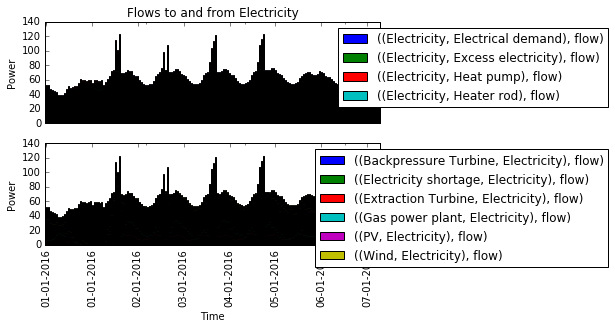

In [27]:
plot(om, 'Electricity')

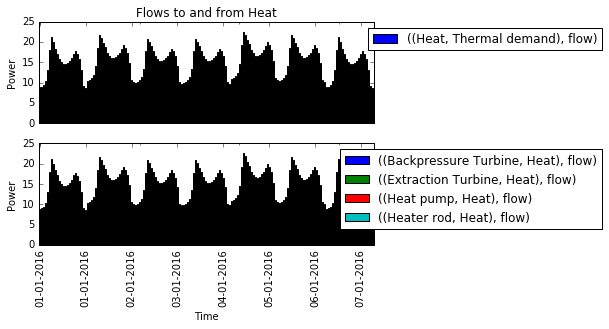

In [26]:
plot(om, 'Heat')

## Adding the mobility sector

![Making it mobile.](images/mobility.png "Mobility? I don't think this thing is going anywhere anymore.")

In [31]:
from oemof.solph.components import GenericStorage as Storage

charging_power = 20
battery_cap = 50

# Battery Electric Vehicles (BEVs)
bevs = Bus(label="BEVs", balanced=True)

# A transformer which transports electricity from the grid to the mobility sector.
charging_stations = Transformer(
    label="Charging Stations",
    inputs={electricity: Flow()},
    outputs={
        bevs: Flow(
            variable_costs=10,
            nominal_value=charging_power,
            max=data['bev_charging_power'],
        )
    },
    conversion_factors={bevs: 1.0},
)

bev_storage = Storage(
    label='BEV Storage',
    inputs={bevs: Flow()},
    outputs={bevs: Flow()},
    nominal_capacity=battery_cap,
    capacity_min=data['bev_cap_min'],
    capacity_max=data['bev_cap_max'],
    capacity_loss=0.00,
    initial_capacity=None,
    inflow_conversion_factor=1.0,
    outflow_conversion_factor=1.0,
    nominal_input_capacity_ratio=1.0,
    nominal_output_capacity_ratio=1.0,
)

# Leaving vehicles are modelled as `Sink`s
leaving_bev = Sink(
    label="Leaving BEV",
    inputs={
        bevs: Flow(
            nominal_value=battery_cap,
            actual_value=data['bev_sink'],
            fixed=True,
        )
    },
)

# Returning vehicles are modelled as `Source`s
returning_bev = Source(
    label="Returning BEV",
    outputs={
        bevs: Flow(
            nominal_value=battery_cap,
            actual_value=data['bev_source'],
            fixed=True,
        )
    },
)
energysystem.add(
    bevs, charging_stations, bev_storage, leaving_bev, returning_bev
)

/home/dozeumgus/work/code/oemof/core/oemof/solph/components.py:219: DeprecationWarning: 
Deprecated. The attributes 'nominal_input_capacity_ratio' and 'nominal_input_capacity_ratio' will be removed in oemof >= v0.3.0.
 Please use the 'invest_relation_...' attribute in case of the investment mode.
 Please use the 'nominal_value' within in the Flows for the dispatch mode.
 These measures will avoid this warning.
  warnings.warn(dpr_msg, DeprecationWarning)


In [32]:
om = optimize(energysystem)

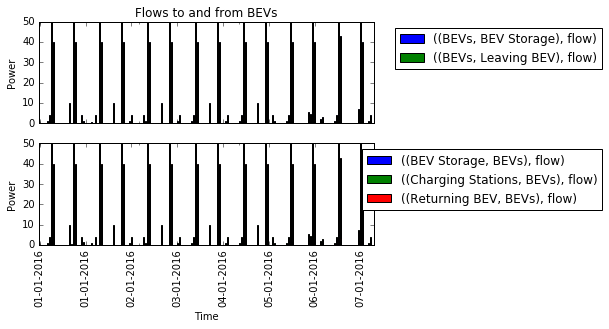

In [33]:
plot(om, 'BEVs')

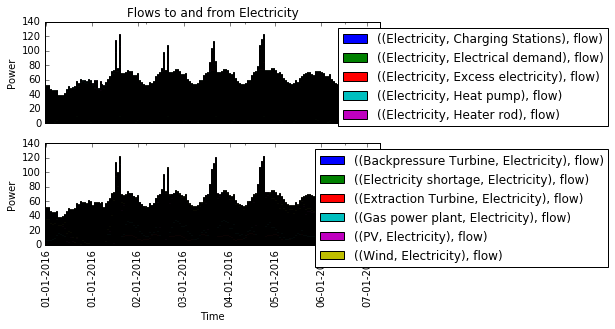

In [34]:
plot(om, 'Electricity')